In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [8]:
import tensorflow as tf

In [10]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.python.keras import layers 
import time

from IPython import display

In [15]:
tf.keras.datatsets.mnist.load_data()

AttributeError: module 'tensorboard.plugins.pr_curve.summary' has no attribute 'pb'

In [18]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images=(train_images-127.5)/127.5 #Normalize

In [19]:
BUFFER_SIZE=60000
BATCH_SIZE=256

In [20]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [23]:
def make_generator_model():
    model=Sequential()
    model.add(Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7,7,256)))
    assert model.output_shape==(None,7,7,256)#None is batch size
    
    model.add(Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape==(None,7,7,128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape==(None,14,14,64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape==(None,28,28,1)
    
    return model

In [32]:
tf.enable_eager_execution()

AttributeError: module 'tensorflow' has no attribute 'enable_eager_execution'

TypeError: Image data cannot be converted to float

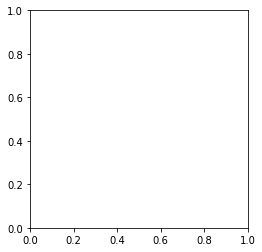

In [31]:
generator=make_generator_model()

noise=tf.random_normal([1,100])
generated_image=generator(noise)#training=False)

plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [ ]:
def make_discriminator_model():
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=[28,28,1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [ ]:
discriminator=make_discriminator_model()
decision=discriminator(generated_image)
print(decision)

Loss

In [ ]:
def discriminator_loss(real_output,fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [ ]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,"ckpt")
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,
                              generator=generator,discriminator=discriminator)

Training Loop